In [ ]:
# to download Dataset : https://insideairbnb.com/get-the-data/

In [1]:
# Load necessary libraries
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import string
from transformers import BertTokenizer, BertModel, pipeline
from torch import nn
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import defaultdict

In [2]:
# Load dataset
df = pd.read_csv('reviews.csv')

In [3]:
# Basic info
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,27934,1094339,2012-04-07,1368195,Michael,We stayed in the apartment for a week and we e...
1,27934,1241042,2012-05-07,2007324,Scott,My girlfriend and I recently stayed in Nuttee'...
2,27934,1523384,2012-06-20,2263352,Marc,I stayed for one month at the condo and was re...
3,27934,1655571,2012-07-08,558987,Leyla,Nuttee was a great host! I really enjoyed her ...
4,27934,1972192,2012-08-13,2359865,Rachel,Nuttee was an amazing host. She and her daught...


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438958 entries, 0 to 438957
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     438958 non-null  int64 
 1   id             438958 non-null  int64 
 2   date           438958 non-null  object
 3   reviewer_id    438958 non-null  int64 
 4   reviewer_name  438953 non-null  object
 5   comments       438901 non-null  object
dtypes: int64(3), object(3)
memory usage: 20.1+ MB
None


In [5]:
df.shape

(438958, 6)

In [6]:
df = df.iloc[:100,:]

In [7]:
# Text Preprocessing: Lowercase, remove stopwords, and punctuation
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
# Data Preprocessing
df['date'] = pd.to_datetime(df['date'])  # Convert date
df['comments'] = df['comments'].fillna('')  # Fill missing comments with empty strings

In [9]:
def preprocess_text(text):
    text = BeautifulSoup(text,"html.parser")
    text = text.get_text().lower()  # Lowercase
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords and non-alphabetic tokens
    return ' '.join(tokens)

df['clean_comments'] = df['comments'].apply(preprocess_text)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Convert text to vectors using BERT embeddings
def bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True)

    # Move input tensors to the GPU if available
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(1).cpu().squeeze().numpy()

# Apply BERT to clean comments
df['embeddings'] = df['clean_comments'].apply(bert_embedding)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
# Load the pre-trained sentiment analysis pipeline
bert_sentiment_analyzer = pipeline('sentiment-analysis', device=0 if torch.cuda.is_available() else -1)

# Apply the BERT-based sentiment analysis to clean comments
def analyze_sentiment(text):
    result = bert_sentiment_analyzer(text)[0]
    return result['label'], result['score']


# Apply to the dataset
df[['sentiment_label', 'sentiment_score']] = df['clean_comments'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Display results
df[['comments', 'sentiment_label', 'sentiment_score']].head()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,comments,sentiment_label,sentiment_score
0,We stayed in the apartment for a week and we e...,POSITIVE,0.999259
1,My girlfriend and I recently stayed in Nuttee'...,POSITIVE,0.992594
2,I stayed for one month at the condo and was re...,POSITIVE,0.992787
3,Nuttee was a great host! I really enjoyed her ...,POSITIVE,0.997826
4,Nuttee was an amazing host. She and her daught...,POSITIVE,0.987587


In [13]:
# Load a pre-trained summarization model (e.g., BART)
# summarizer = pipeline('summarization', model='facebook/bart-large-cnn', device=0 if torch.cuda.is_available() else -1)
summarizer = pipeline('summarization', model='t5-small', device=0 if torch.cuda.is_available() else -1)
# Apply summarization to comments
def summarize_review(text):
    # We summarize if the review has more than 50 words (you can adjust as needed)
    if len(text.split()) > 50:
        summary = summarizer(text, max_length=50, min_length=25, do_sample=False)[0]['summary_text']
        return summary
    return text

# Apply summarization to the dataset
df['summary'] = df['comments'].apply(summarize_review)

# Display the summarized reviews
df[['comments', 'summary']].head()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


,comments,summary
0,We stayed in the apartment for a week and we e...,"Nuttee is a very nice host, and she did her be..."
1,My girlfriend and I recently stayed in Nuttee'...,"Nuttee was out of town, but was still very acc..."
2,I stayed for one month at the condo and was re...,"the condo is at the 19th floor, quiet, modern ..."
3,Nuttee was a great host! I really enjoyed her ...,the apartment itself is really spacious for a ...
4,Nuttee was an amazing host. She and her daught...,"it's a studio apartment, with a classy partiti..."


In [14]:
# Use TF-IDF to identify key topics
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['clean_comments'])
feature_names = tfidf.get_feature_names_out()

def get_top_keywords(doc, n=10):
    # Get the TF-IDF scores for the document
    sorted_indices = doc.toarray()[0].argsort()[::-1]  # Sort indices by score
    top_indices = sorted_indices[:n]  # Get top N indices
    top_keywords = [feature_names[i] for i in top_indices]
    return top_keywords

# Get top 10 keywords for each document
df['key_topics'] = [get_top_keywords(doc) for doc in tfidf_matrix]

# Display comments along with the top 10 keywords
df[['comments', 'key_topics']].head()


,comments,key_topics
0,We stayed in the apartment for a week and we e...,"[mins, central, apartment, stalls, lot, love, ..."
1,My girlfriend and I recently stayed in Nuttee'...,"[condo, great, perfect, recently, possible, se..."
2,I stayed for one month at the condo and was re...,"[cheap, music, realy, city, assistant, feel, v..."
3,Nuttee was a great host! I really enjoyed her ...,"[relaxing, walking, day, walk, apartment, real..."
4,Nuttee was an amazing host. She and her daught...,"[huge, little, bed, though, condominium, sleep..."


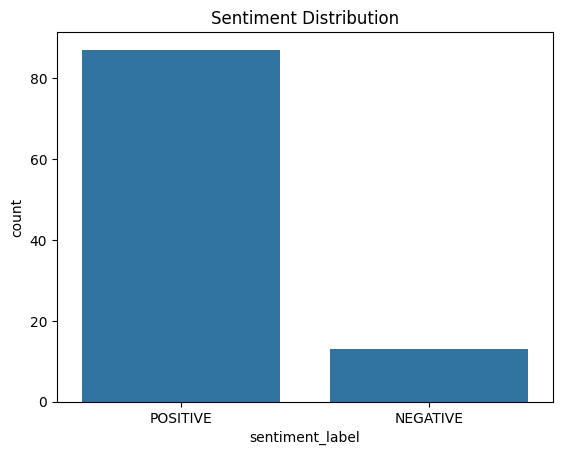

In [15]:
# Plot Sentiment Distribution
sns.countplot(x='sentiment_label', data=df)
plt.title('Sentiment Distribution')
plt.show()

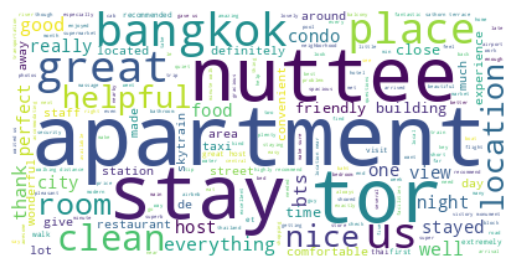

In [16]:
# Word Cloud for most common words
from wordcloud import WordCloud

text = ' '.join(df['clean_comments'])
wordcloud = WordCloud(background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [77]:
df[['comments', 'clean_comments', 'sentiment_label', 'sentiment_score', 'summary', 'key_topics']].head()

,comments,clean_comments,sentiment_label,sentiment_score,summary,key_topics
0,We stayed in the apartment for a week and we e...,stayed apartment week enjoyed much nuttee nice...,POSITIVE,0.999259,"Nuttee is a very nice host, and she did her be...","[mins, central, apartment, stalls, lot, love, ..."
1,My girlfriend and I recently stayed in Nuttee'...,girlfriend recently stayed nuttee condo month ...,POSITIVE,0.992594,"Nuttee was out of town, but was still very acc...","[condo, great, perfect, recently, possible, se..."
2,I stayed for one month at the condo and was re...,stayed one month condo realy pleased condo flo...,POSITIVE,0.992787,"the condo is at the 19th floor, quiet, modern ...","[cheap, music, realy, city, assistant, feel, v..."
3,Nuttee was a great host! I really enjoyed her ...,nuttee great host really enjoyed apartment abs...,POSITIVE,0.997826,the apartment itself is really spacious for a ...,"[relaxing, walking, day, walk, apartment, real..."
4,Nuttee was an amazing host. She and her daught...,nuttee amazing host daughter waited us lobby g...,POSITIVE,0.987587,"it's a studio apartment, with a classy partiti...","[huge, little, bed, though, condominium, sleep..."


In [19]:
print("Review: ", df['comments'][4])
print()
print("Cleaned Review: ", df['clean_comments'][4])
print()
print("Sentiment Label: ", df['sentiment_label'][4])
print()
print("Sentiment Score: ", df['sentiment_score'][4])
print()
print("Summary: ", df['summary'][4])
print()
print("Topics: ", df['key_topics'][4])
print()

Review:  Nuttee was an amazing host. She and her daughter waited for us at the lobby and gave us a quick rundown of the place. It's a studio apartment, with a classy partition dividing the bedroom from the living room -- and the view from the balcony is awesome. Bed was huge, but if you're coming in a group of 3, the sofa may not always be the most comfortable place for the last guy (bed IS huge enough for three to sleep in though). Shower pressure in the main bathroom was a little low, but we could deal with it. Make sure to ask Nuttee or her assistant to write down the condominium's address for you in Thai, though it will be best if you print out a map yourself -- most of our taxi/tuk-tuk/motorcycle drivers needed a little pointer about where exactly it was. That said, it was a very central location, just slightly away from the sometimes overwhelming hustle and bustle of Pratunam. Warmly recommended. 

Cleaned Review:  nuttee amazing host daughter waited us lobby gave us quick rundow